# Week 5: Interpretability 2: Feature visualisation and TSNE

Tutorial by Cher Bass and Emma Robinson 

In this second tutorial session on interpretability we will look at feature visualisation approaches, specifically layer visualisation through gradient ascent. Then we will look at using these for style transfer using Deep Dream and finally we will look at interpretation of network latent space embedddings using T-SNE

First let's mount our Drive and import the libraries we will need. As for part 1, we create examples based on code from the [visualizations repository](https://github.com/utkuozbulak/pytorch-cnn-visualizations). 

**Note** All the visualizations will be saved to `/generated` folder

In [3]:

from google.colab import drive
drive.mount('/content/drive')

# STUDENTS UPLOAD the Notebooks folder to your drive and specify the path to where you have placed the visualisations package folder
%cd /content/drive/My\ Drive/Colab\ Notebooks/AdvancedML/2021/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/AdvancedML/2021


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np 
import visualizations
from visualizations.src.misc_functions import *
from visualizations.src.deep_dream import DeepDream

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Visualisation

The web journal [Distill.pub](https://distill.pub/) is a particularly strong source of information for those interested in network visualisation. In particular [this article](https://distill.pub/2017/feature-visualization/) by Chris Olah has been a strong source of information for this section.

The idea of feature visualisation is that we perform backpropagation, similarly to how it is performed when optimising the network. However, for visualisation, we keep the weights ($\mathbf{w}$) constant and instead optimise an activation $f(\mathbf{w,x})$ with respect to  input image $\mathbf{x}$. 

$$ \mathbf{x^*} = \max_{x s.t. || \mathbf{x}|| = \rho} f(\mathbf{w,x}) $$

Such that: $\mathbf{x_{t+1}}= \mathbf{x_{t}}- \gamma \frac{\delta f(\mathbf{w,x}}{\delta \mathbf{x}}$

### **Exercise 1. CNN Layer Visualization** 

Here we will use the layer visualisation approach of ([Erhan et al 2009](https://www.researchgate.net/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network ))

The first thing we need to do is load a pre-trained VGG16 model:
 


In [5]:
# load vgg model, and extract layers from the features modules only
pretrained_model = models.vgg16(pretrained=True).features
print(pretrained_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_s

#### **Exercise 1.1 Implementing layer visualisation**

Implement the gradient update step for layer visualisation. Here you are updating the image for a specific channel of a specific layer. Thus the function has to make a stepwise forward pass through the network until it reaches the `selected_layer`. The output of these forward pass is then the target activation block. This must then be sliced to return the `selected_channel` to optimise against.

**To do**

1. Slice the correct channel from the activation returned from `selected_layer` (line 33). The layers activations are returned by using a for loop to perform a forward step by step until the correct layer is reached (lines 27-31)
2. Suggest a suitable loss function (line 35). Don't forget, the goal here is to maximise activation strength across the whole channel.

**Note** how, in the above function, the optimizer (line 20) is optimising against the `[processed_image]` rather than the network parameters. After tha the training is implemented as for standard network training (with `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()` implemented exactly as seen before)



In [79]:
from scipy.ndimage import gaussian_filter

def visualise_layer(selected_layer,selected_channel,model,processed_image,lr=0.1,iters=50,l2_reg=1e-4,regularise=False):
        '''
        Function for layer regulairsation adapted from @utkuozbulak visualisation library
        
        input:
        
        selected_layer (int): index of chosen layer
        selected_channel (int): index of chosen channel (corresponding to specific filter)
        model: network object
        processed_image (pytorch float tensor): resized and normalised input image (or random noise array)
        reg_lambda (float): L2 regularisation lambda
        output:
        
        processed_image: optimised layer visualisation
        
        '''
        
        if regularise:
          # STUDENT CODE ex 1.3 implement optimizer with weight decay
          optimizer = torch.optim.Adam([processed_image], lr=lr,weight_decay=l2_reg)
        else:
          # Define optimizer for the image
          optimizer = torch.optim.Adam([processed_image], lr=lr)

        x = processed_image
        for i in range(1, iters):
            optimizer.zero_grad()

            # Forward pass through network one layer at a time 
            for index, layer in enumerate(model):         
                x = layer(x) #forward pass though current layer
                #stop once target layer is reacher
                if index == selected_layer:
                  break
            # STUDENT CODE 1.1 - slice a filter from the layer to get a 2D output
            conv_output = x[0, selected_channel]
            # STUDENT CODE 1.1 - Implement Loss function - we need to maximise activations across the layer
            loss = -torch.mean(conv_output) 
            # Backward
            loss.backward()
           
            # Update image
            optimizer.step()
            
            # Assign processed image to a variable to move forward in the model
            x = processed_image
            
            if regularise:
                # # Ex 1.3 implement gaussian blurring
                blur=gaussian_filter(x.detach().numpy(), sigma=blur_sigma)
                x.data=torch.from_numpy(blur)

            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            if i % 10 == 0:
                created_image = recreate_image(processed_image)  
                im_path = './generated/ddream_l' + str(selected_layer) + \
                    '_f' + str(selected_channel) + '_iter' + str(i) + '.jpg'
                plt.imshow(created_image)
                plt.show()
        return processed_image
            
                


#### **Exercise 1.2  Train layer visualisation**

**To Do** train with different layers and filters

In this case our starting point is an `image` of random noise. Note, the function expects the image as a numpy integer array. `visualizations.src.misc_functions.preprocess_image` resizes and normalises the image to match the form expected by the network.

Iteration: 1 Loss: 0.70
Iteration: 2 Loss: 0.54
Iteration: 3 Loss: -2.35
Iteration: 4 Loss: -8.16
Iteration: 5 Loss: -16.95
Iteration: 6 Loss: -28.63
Iteration: 7 Loss: -41.83
Iteration: 8 Loss: -56.76
Iteration: 9 Loss: -73.04
Iteration: 10 Loss: -90.28


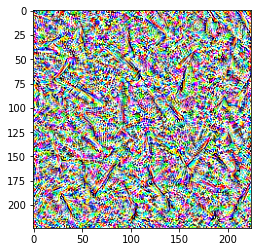

Iteration: 11 Loss: -109.20
Iteration: 12 Loss: -129.60
Iteration: 13 Loss: -150.77
Iteration: 14 Loss: -173.20
Iteration: 15 Loss: -196.62
Iteration: 16 Loss: -220.93
Iteration: 17 Loss: -246.42
Iteration: 18 Loss: -272.73
Iteration: 19 Loss: -299.84
Iteration: 20 Loss: -328.10


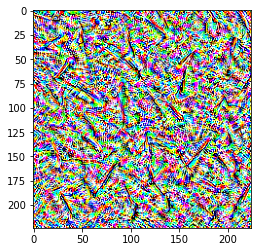

Iteration: 21 Loss: -357.18
Iteration: 22 Loss: -386.89
Iteration: 23 Loss: -417.48
Iteration: 24 Loss: -448.87
Iteration: 25 Loss: -480.92
Iteration: 26 Loss: -513.67
Iteration: 27 Loss: -546.98
Iteration: 28 Loss: -581.15
Iteration: 29 Loss: -615.96
Iteration: 30 Loss: -651.31


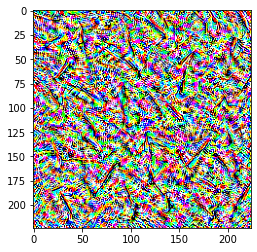

Iteration: 31 Loss: -687.48
Iteration: 32 Loss: -724.25
Iteration: 33 Loss: -761.54
Iteration: 34 Loss: -799.56
Iteration: 35 Loss: -838.14
Iteration: 36 Loss: -877.11
Iteration: 37 Loss: -916.36
Iteration: 38 Loss: -956.17
Iteration: 39 Loss: -996.35
Iteration: 40 Loss: -1037.04


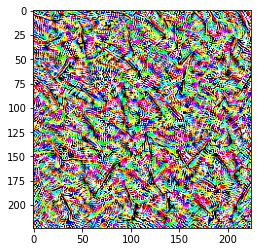

Iteration: 41 Loss: -1078.04
Iteration: 42 Loss: -1119.40
Iteration: 43 Loss: -1161.05
Iteration: 44 Loss: -1203.36
Iteration: 45 Loss: -1246.01
Iteration: 46 Loss: -1288.67
Iteration: 47 Loss: -1331.70
Iteration: 48 Loss: -1375.16
Iteration: 49 Loss: -1418.88
Iteration: 50 Loss: -1462.89


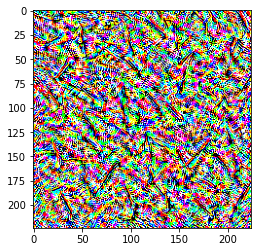

Iteration: 51 Loss: -1507.14
Iteration: 52 Loss: -1551.73
Iteration: 53 Loss: -1596.38
Iteration: 54 Loss: -1641.38
Iteration: 55 Loss: -1686.57
Iteration: 56 Loss: -1732.08
Iteration: 57 Loss: -1777.63
Iteration: 58 Loss: -1823.41
Iteration: 59 Loss: -1869.35
Iteration: 60 Loss: -1915.37


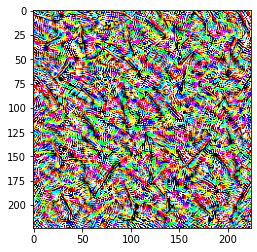

Iteration: 61 Loss: -1961.62
Iteration: 62 Loss: -2008.09
Iteration: 63 Loss: -2054.72
Iteration: 64 Loss: -2101.36
Iteration: 65 Loss: -2148.28
Iteration: 66 Loss: -2195.43
Iteration: 67 Loss: -2242.73
Iteration: 68 Loss: -2290.14
Iteration: 69 Loss: -2337.73
Iteration: 70 Loss: -2385.33


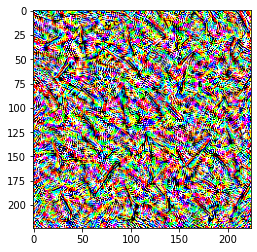

Iteration: 71 Loss: -2433.08
Iteration: 72 Loss: -2481.02
Iteration: 73 Loss: -2529.07
Iteration: 74 Loss: -2577.24
Iteration: 75 Loss: -2625.58
Iteration: 76 Loss: -2673.95
Iteration: 77 Loss: -2722.37
Iteration: 78 Loss: -2770.86
Iteration: 79 Loss: -2819.41
Iteration: 80 Loss: -2868.01


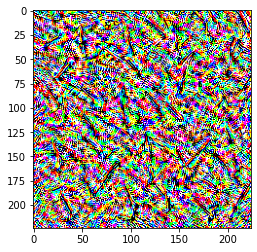

Iteration: 81 Loss: -2916.75
Iteration: 82 Loss: -2965.78
Iteration: 83 Loss: -3014.74
Iteration: 84 Loss: -3063.82
Iteration: 85 Loss: -3112.98
Iteration: 86 Loss: -3162.25
Iteration: 87 Loss: -3211.54
Iteration: 88 Loss: -3260.91
Iteration: 89 Loss: -3310.48
Iteration: 90 Loss: -3360.21


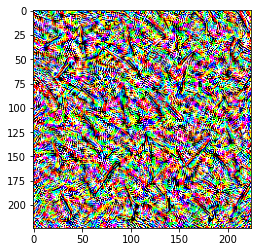

Iteration: 91 Loss: -3409.86
Iteration: 92 Loss: -3459.71
Iteration: 93 Loss: -3509.56
Iteration: 94 Loss: -3559.40
Iteration: 95 Loss: -3609.34
Iteration: 96 Loss: -3659.20
Iteration: 97 Loss: -3709.49
Iteration: 98 Loss: -3759.70
Iteration: 99 Loss: -3809.96


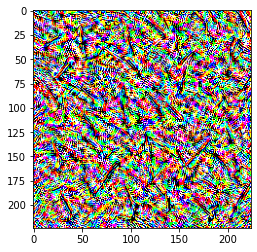

In [81]:
cnn_layer =28
cnn_filter=2

random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
# Process image and return variable
processed_image = preprocess_image(random_image, False)
       
layer_vis = visualise_layer(cnn_layer,cnn_filter,pretrained_model,processed_image,iters=100, lr=0.5)

# plot image

# Recreate image - removes intensity normalisation
created_image = recreate_image(layer_vis)  
plt.imshow(created_image)
plt.show()


#### **Exercise 1.3 (optional) regularisation**

1. L2 regularisation can be implemented in PyTorch using the `weight_decay` argument of the optimiser. Try adding different levels of L2 regularisation this way
2. Consider also implementing activation/gradient clipping or Gaussian blurring?

Iteration: 1 Loss: 0.59
Iteration: 2 Loss: -0.57
Iteration: 3 Loss: -1.63
Iteration: 4 Loss: -4.10
Iteration: 5 Loss: -6.35
Iteration: 6 Loss: -10.05
Iteration: 7 Loss: -14.21
Iteration: 8 Loss: -20.46
Iteration: 9 Loss: -26.91
Iteration: 10 Loss: -33.51


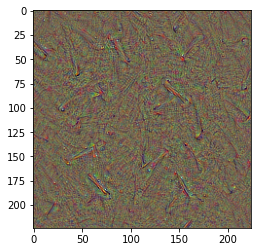

Iteration: 11 Loss: -39.85
Iteration: 12 Loss: -45.86
Iteration: 13 Loss: -50.69
Iteration: 14 Loss: -55.23
Iteration: 15 Loss: -57.63
Iteration: 16 Loss: -60.16
Iteration: 17 Loss: -62.16
Iteration: 18 Loss: -65.92
Iteration: 19 Loss: -69.00
Iteration: 20 Loss: -73.68


Iteration: 21 Loss: -78.12
Iteration: 22 Loss: -82.85
Iteration: 23 Loss: -87.44
Iteration: 24 Loss: -92.50
Iteration: 25 Loss: -96.73
Iteration: 26 Loss: -101.04
Iteration: 27 Loss: -103.94
Iteration: 28 Loss: -108.64
Iteration: 29 Loss: -111.73
Iteration: 30 Loss: -114.97


Iteration: 31 Loss: -118.23
Iteration: 32 Loss: -121.42
Iteration: 33 Loss: -123.82
Iteration: 34 Loss: -126.30
Iteration: 35 Loss: -127.82
Iteration: 36 Loss: -130.69
Iteration: 37 Loss: -132.60
Iteration: 38 Loss: -136.80
Iteration: 39 Loss: -139.67
Iteration: 40 Loss: -143.23


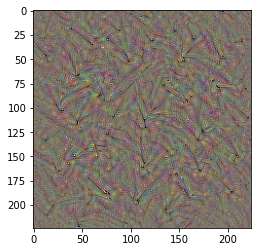

Iteration: 41 Loss: -144.82
Iteration: 42 Loss: -146.69
Iteration: 43 Loss: -147.02
Iteration: 44 Loss: -149.58
Iteration: 45 Loss: -151.05
Iteration: 46 Loss: -153.79
Iteration: 47 Loss: -154.93
Iteration: 48 Loss: -157.56
Iteration: 49 Loss: -158.59
Iteration: 50 Loss: -160.27


Iteration: 51 Loss: -161.89
Iteration: 52 Loss: -163.21
Iteration: 53 Loss: -165.07
Iteration: 54 Loss: -165.65
Iteration: 55 Loss: -166.46
Iteration: 56 Loss: -168.59
Iteration: 57 Loss: -168.91
Iteration: 58 Loss: -170.12
Iteration: 59 Loss: -169.49
Iteration: 60 Loss: -170.96


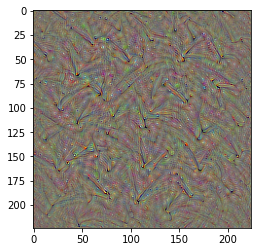

Iteration: 61 Loss: -170.73
Iteration: 62 Loss: -172.46
Iteration: 63 Loss: -172.65
Iteration: 64 Loss: -175.12
Iteration: 65 Loss: -176.40
Iteration: 66 Loss: -177.83
Iteration: 67 Loss: -178.91
Iteration: 68 Loss: -179.83
Iteration: 69 Loss: -179.95
Iteration: 70 Loss: -181.54


Iteration: 71 Loss: -182.13
Iteration: 72 Loss: -183.74
Iteration: 73 Loss: -183.62
Iteration: 74 Loss: -184.82
Iteration: 75 Loss: -184.85
Iteration: 76 Loss: -185.78
Iteration: 77 Loss: -186.35
Iteration: 78 Loss: -188.71
Iteration: 79 Loss: -189.62
Iteration: 80 Loss: -190.65


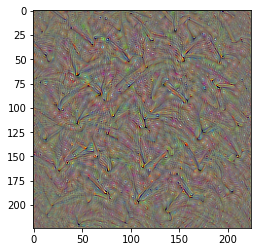

Iteration: 81 Loss: -190.44
Iteration: 82 Loss: -191.26
Iteration: 83 Loss: -189.85
Iteration: 84 Loss: -190.89
Iteration: 85 Loss: -190.88
Iteration: 86 Loss: -192.72
Iteration: 87 Loss: -193.53
Iteration: 88 Loss: -194.91
Iteration: 89 Loss: -194.28
Iteration: 90 Loss: -194.36


Iteration: 91 Loss: -193.60
Iteration: 92 Loss: -194.69
Iteration: 93 Loss: -194.29
Iteration: 94 Loss: -196.06
Iteration: 95 Loss: -197.83
Iteration: 96 Loss: -199.40
Iteration: 97 Loss: -199.23
Iteration: 98 Loss: -199.92
Iteration: 99 Loss: -199.81


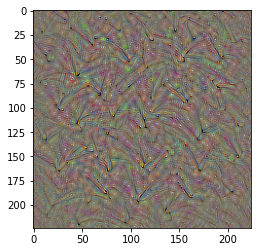

In [84]:
cnn_layer =28
cnn_filter=2

random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
# Process image and return variable
processed_image = preprocess_image(random_image, False)
       
layer_vis = visualise_layer(cnn_layer,cnn_filter,pretrained_model,processed_image,iters=100, lr=0.5,l2_reg=1e-2,regularise=True)

# plot image

# Recreate image - removes intensity normalisation
created_image = recreate_image(layer_vis)  

plt.imshow(created_image)
plt.show()


## **Exercise 2: Deep Dream**


In deep dream, rather than optimising for a random image we instead pass a real image. Let's visualise the output from a later layer.

In [65]:
# THIS OPERATION IS MEMORY HUNGRY! #
# Because of the selected image is very large
# If it gives out of memory error or locks the computer
# Try it with a smaller image
cnn_layer = 28
filter_pos = 94

im_path = './visualizations/input_images/dd_tree.jpg'

image=Image.open(im_path).convert('RGB')
plt.imshow(image)
plt.show()

processed_image = preprocess_image(image, True)


Iteration: 1 Loss: 5.84
Iteration: 2 Loss: 2.98
Iteration: 3 Loss: -1.18
Iteration: 4 Loss: -5.77
Iteration: 5 Loss: -11.82
Iteration: 6 Loss: -18.30
Iteration: 7 Loss: -25.16
Iteration: 8 Loss: -32.05
Iteration: 9 Loss: -38.60
Iteration: 10 Loss: -45.22


Iteration: 11 Loss: -51.66
Iteration: 12 Loss: -58.26
Iteration: 13 Loss: -64.81
Iteration: 14 Loss: -70.94
Iteration: 15 Loss: -77.01
Iteration: 16 Loss: -83.08
Iteration: 17 Loss: -89.11
Iteration: 18 Loss: -95.33
Iteration: 19 Loss: -101.56
Iteration: 20 Loss: -107.82


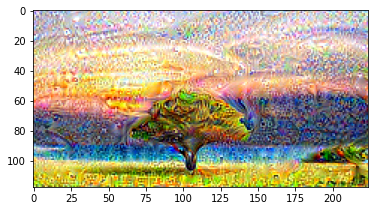

Iteration: 21 Loss: -114.10
Iteration: 22 Loss: -120.41
Iteration: 23 Loss: -126.67
Iteration: 24 Loss: -132.96
Iteration: 25 Loss: -139.20
Iteration: 26 Loss: -145.41
Iteration: 27 Loss: -151.66
Iteration: 28 Loss: -158.03
Iteration: 29 Loss: -164.32
Iteration: 30 Loss: -170.65


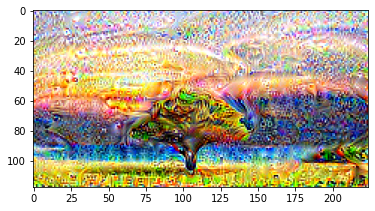

Iteration: 31 Loss: -177.04
Iteration: 32 Loss: -183.39
Iteration: 33 Loss: -189.66
Iteration: 34 Loss: -195.94
Iteration: 35 Loss: -202.26
Iteration: 36 Loss: -208.64
Iteration: 37 Loss: -215.04
Iteration: 38 Loss: -221.52
Iteration: 39 Loss: -228.00
Iteration: 40 Loss: -234.48


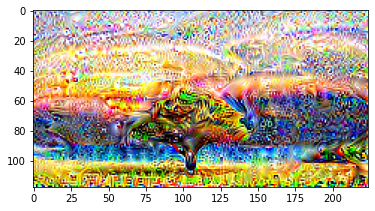

Iteration: 41 Loss: -240.97
Iteration: 42 Loss: -247.47
Iteration: 43 Loss: -253.85
Iteration: 44 Loss: -260.36
Iteration: 45 Loss: -266.87
Iteration: 46 Loss: -273.41
Iteration: 47 Loss: -280.00
Iteration: 48 Loss: -286.52
Iteration: 49 Loss: -293.17
Iteration: 50 Loss: -299.76


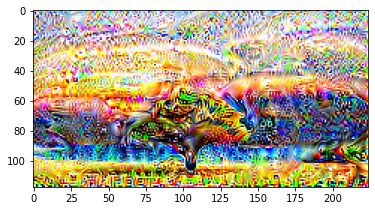

Iteration: 51 Loss: -306.45
Iteration: 52 Loss: -313.19
Iteration: 53 Loss: -319.90
Iteration: 54 Loss: -326.77
Iteration: 55 Loss: -333.54
Iteration: 56 Loss: -340.35
Iteration: 57 Loss: -347.14
Iteration: 58 Loss: -354.01
Iteration: 59 Loss: -360.88
Iteration: 60 Loss: -367.82


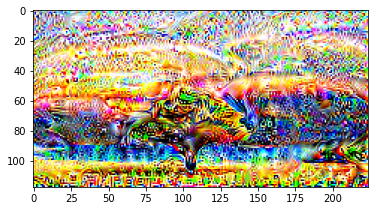

Iteration: 61 Loss: -374.76
Iteration: 62 Loss: -381.71
Iteration: 63 Loss: -388.64
Iteration: 64 Loss: -395.69
Iteration: 65 Loss: -402.70
Iteration: 66 Loss: -409.75
Iteration: 67 Loss: -416.76
Iteration: 68 Loss: -423.82
Iteration: 69 Loss: -430.94
Iteration: 70 Loss: -438.08


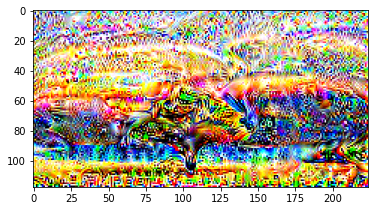

Iteration: 71 Loss: -445.24
Iteration: 72 Loss: -452.48
Iteration: 73 Loss: -459.75
Iteration: 74 Loss: -467.03
Iteration: 75 Loss: -474.30
Iteration: 76 Loss: -481.57
Iteration: 77 Loss: -488.90
Iteration: 78 Loss: -496.27
Iteration: 79 Loss: -503.61
Iteration: 80 Loss: -511.04


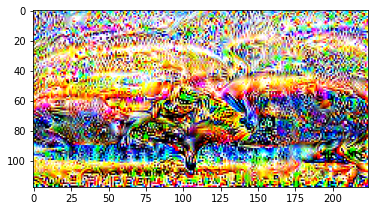

Iteration: 81 Loss: -518.48
Iteration: 82 Loss: -525.95
Iteration: 83 Loss: -533.42
Iteration: 84 Loss: -540.92
Iteration: 85 Loss: -548.41
Iteration: 86 Loss: -555.96
Iteration: 87 Loss: -563.53
Iteration: 88 Loss: -571.12
Iteration: 89 Loss: -578.70
Iteration: 90 Loss: -586.33


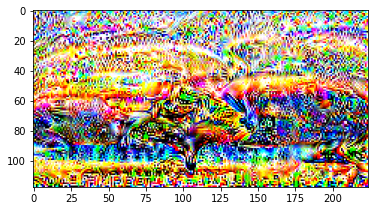

Iteration: 91 Loss: -593.93
Iteration: 92 Loss: -601.54
Iteration: 93 Loss: -609.22
Iteration: 94 Loss: -616.87
Iteration: 95 Loss: -624.55
Iteration: 96 Loss: -632.28
Iteration: 97 Loss: -640.03
Iteration: 98 Loss: -647.81
Iteration: 99 Loss: -655.59


In [66]:
layer_vis = visualise_layer(cnn_layer,filter_pos,pretrained_model,processed_image,lr=0.1,iters=100, regularise=False)

**To do** Try changing the learning rate or levels of regularisation.

Now you can try uploading a photo of yourself and giving it the DeepDream treatment!

## **Exercise 3 T-SNE**

Experiment with t-sne using the [scikit-learn implementation](xhttps://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). In its most basic form this can be done in one line

<img src="https://drive.google.com/uc?id=1KqHdu9VY9O99QVpMF0JqKWrMLa4QoXiq" alt="Drawing" style="width: 500px;"/>

For this exercise we will again use the data from notebook `1.1-fundamentals-solutions.ipynb` ("prem_vs_termwrois.pkl" - available from week 1 section of keats). This represents mean vales of three different types of cortical imaging data: cortical thickness, cortical folding and cortical myelination, all averaged within 100 regions of interest ROIS on the surface (300 features in total). There are 101 babies, 50 terms and 51 preterms. 

<img src="https://drive.google.com/uc?id=1ZbAn0R_ihQ4DCe1XyKaHIRZSvUQv3puh" alt="Drawing" style="width: 800px;"/>

**To do**

1. implement t-sne using scikit learn. Set `n_components=2`; fit the embedding for the dHCP data
2. experiment with changing the perplexity n the range 5 to 50
3. experiment with changing the metric to other options available through [`scipy.spatial.distance.pdista](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) to e.g. correlation
4. In each instance plot the embedding with the points color coded by label

(101, 2)


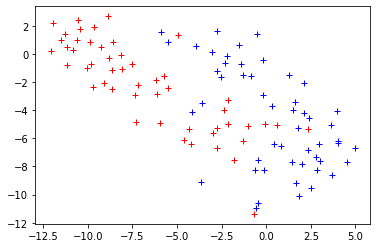

In [98]:
import pandas as pd
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import copy

# STUDENTS CODE HERE - UPDATE THE PATH TO CORRESPOND TO WHERE YOU HAVE UPLOADED prem_vs_termwrois.pkl TO YOUR DRIVE #
file_path='/content/drive/My Drive/Colab Notebooks/AdvancedML/2021/01_fundamentals/prem_vs_termwrois.pkl'
# Read the data
df = pd.read_pickle(file_path)
data = df.values[:,:-2]
y = df.values[:,-1]

perplexity=25

tsne = manifold.TSNE(n_components=2, init='random',random_state=0, metric='correlation', perplexity=perplexity)

Y = tsne.fit_transform(data)

print(Y.shape)

plt.plot(Y[y==1,0],Y[y==1,1],'b+')
plt.plot(Y[y==0,0],Y[y==0,1],'r+')

# Source references

1. [visualizing-convolution-neural-networks-using-pytorch](https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e)
2. [DeepLearning-PadhAI](https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=uQI9jHcP6xfP)